

#  ASR Automate Speech Recognition
* STT (Speech to Text)



* First, speech recognition that allows the machine to catch the words, phrases and sentences we speak

* Second, natural language processing to allow the machine to understand what we speak, and

* Third, speech synthesis to allow the machine to speak.

# Difficulties in developing a speech recognition system

* Size of the vocabulary − Size of the vocabulary impacts the ease of developing an ASR. Consider the following sizes of vocabulary for a better understanding.

 * A small size vocabulary consists of 2-100 words, for example, as in a voice-menu system

 * A medium size vocabulary consists of several 100s to 1,000s of words, for example, as in a database-retrieval task

 * A large size vocabulary consists of several 10,000s of words, as in a general dictation task.





* **Channel characteristics** − Channel quality is also an important dimension. For example, human speech contains high bandwidth with full frequency range, while a telephone speech consists of low bandwidth with limited frequency range. Note that it is harder in the latter.

* **Speaking mode**− Ease of developing an ASR also depends on the speaking mode, that is whether the speech is in isolated word mode, or connected word mode, or in a continuous speech mode. Note that a continuous speech is harder to recognize.

* **Speaking style** − A read speech may be in a formal style, or spontaneous and conversational with casual style. The latter is harder to recognize.
* **Speaker dependency**− Speech can be speaker dependent, speaker adaptive, or speaker independent. A speaker independent is the hardest to build.

* **Type of noise** bold text − Noise is another factor to consider while developing an ASR. Signal to noise ratio may be in various ranges, depending on the acoustic environment that observes less versus more background noise
 * If the signal to noise ratio is greater than 30dB, it is considered as high range

 * If the signal to noise ratio lies between 30dB to 10db, it is considered as medium SNR

 * If the signal to noise ratio is lesser than 10dB, it is considered as low range

* **Microphone characteristics** − The quality of microphone may be good, average, or below average. Also, the distance between mouth and micro-phone can vary. These factors also should be considered for recognition systems.

# Simple audio recognition: Recognizing keywords

**DataSet:**

**speech_commands**


An audio dataset of spoken words designed to help train and evaluate keyword spotting systems. Its primary goal is to provide a way to build and test small models that detect when a single word is spoken, from a set of ten target words, with as few false positives as possible from background noise or unrelated speech. Note that in the train and validation set, the label "unknown" is much more prevalent than the labels of the target words or background noise. One difference from the release version is the handling of silent segments. While in the test set the silence segments are regular 1 second files, in the training they are provided as long segments under "background_noise" folder. Here we split these background noise into 1 second clips, and also keep one of the files for the validation set.
[link](https://www.tensorflow.org/datasets/catalog/speech_commands)

In [ ]:
!pip install -U -q tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 52.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 22 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 6s (75.1 MB/s)
(Reading database ... 122518 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 2s 0us/step


In [ ]:
from IPython.display import Audio, display

display(Audio('data/mini_speech_commands/down/004ae714_nohash_0.wav', autoplay=True))

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['left' 'no' 'right' 'stop' 'yes' 'down' 'README.md' 'go' 'up']


In [ ]:
type(commands)

numpy.ndarray

In [ ]:
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['left' 'no' 'right' 'stop' 'yes' 'down' 'go' 'up']


In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [ ]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
val_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis:

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

In [ ]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The utils.audio_dataset_from_directory function only returns up to two splits. It's a good idea to keep a test set separate from your validation set. Ideally you'd keep it in a separate directory, but in this case you can use Dataset.shard to split the validation set into two halves. Note that iterating over any shard will load all the data, and only keep its fraction.

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [ ]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

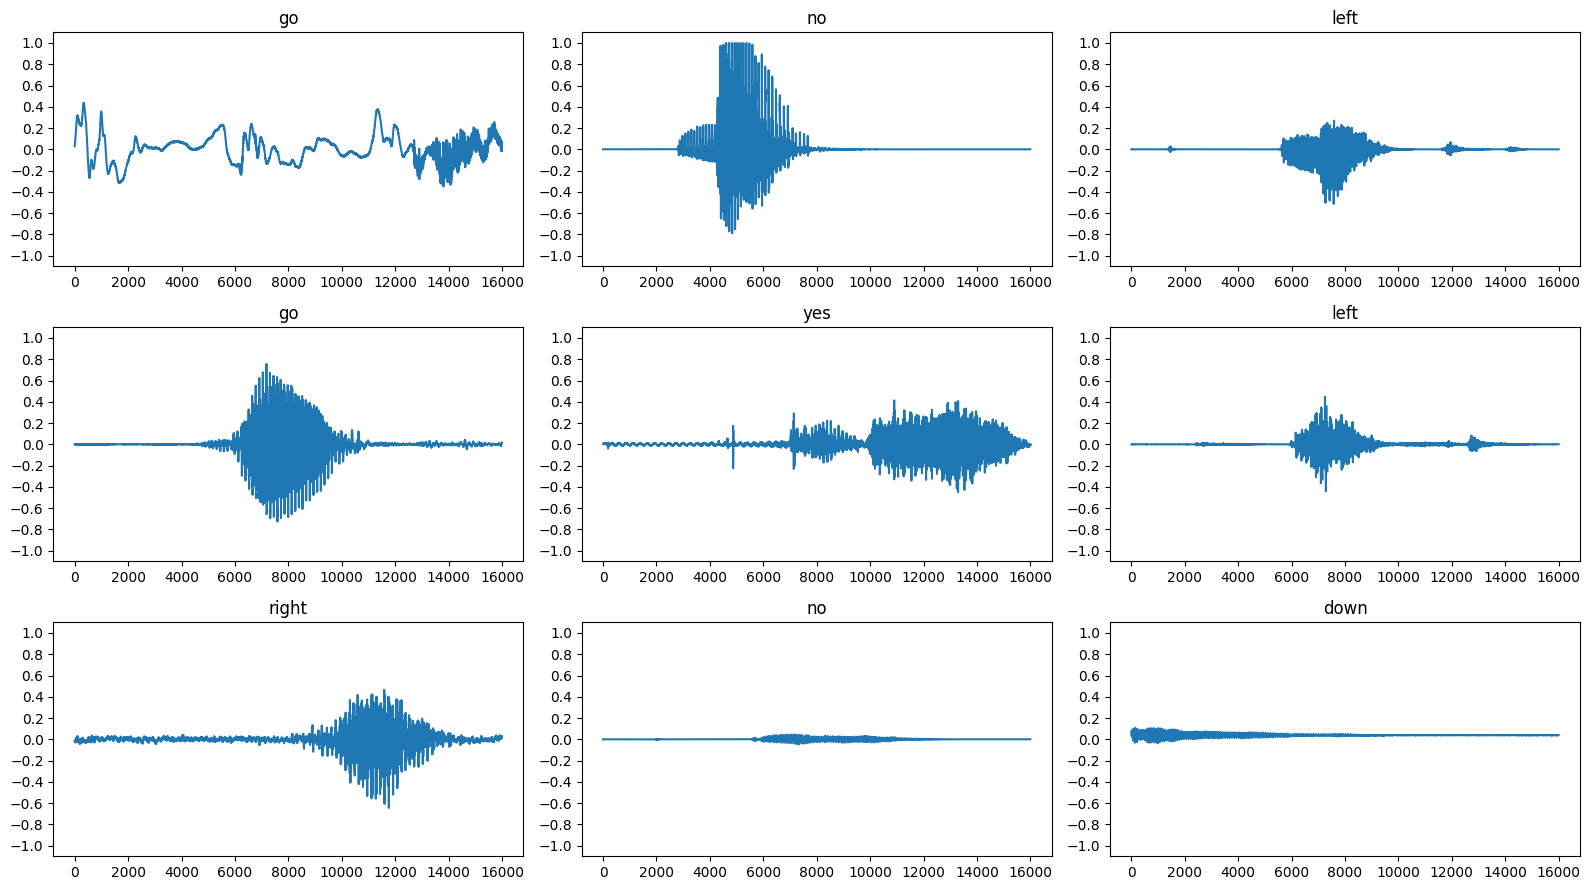

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])
plt.tight_layout()
plt.show()

# Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the short-time Fourier transform (STFT) to convert the waveforms to as spectrograms, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

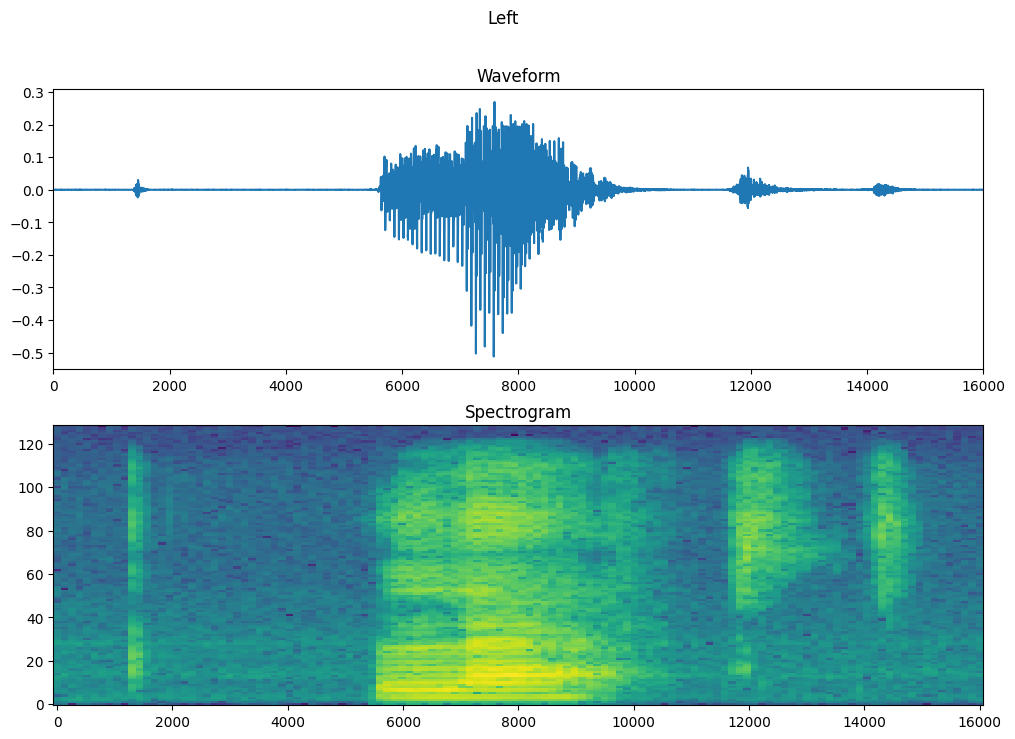

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogramn datasets from the audio datasets:

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

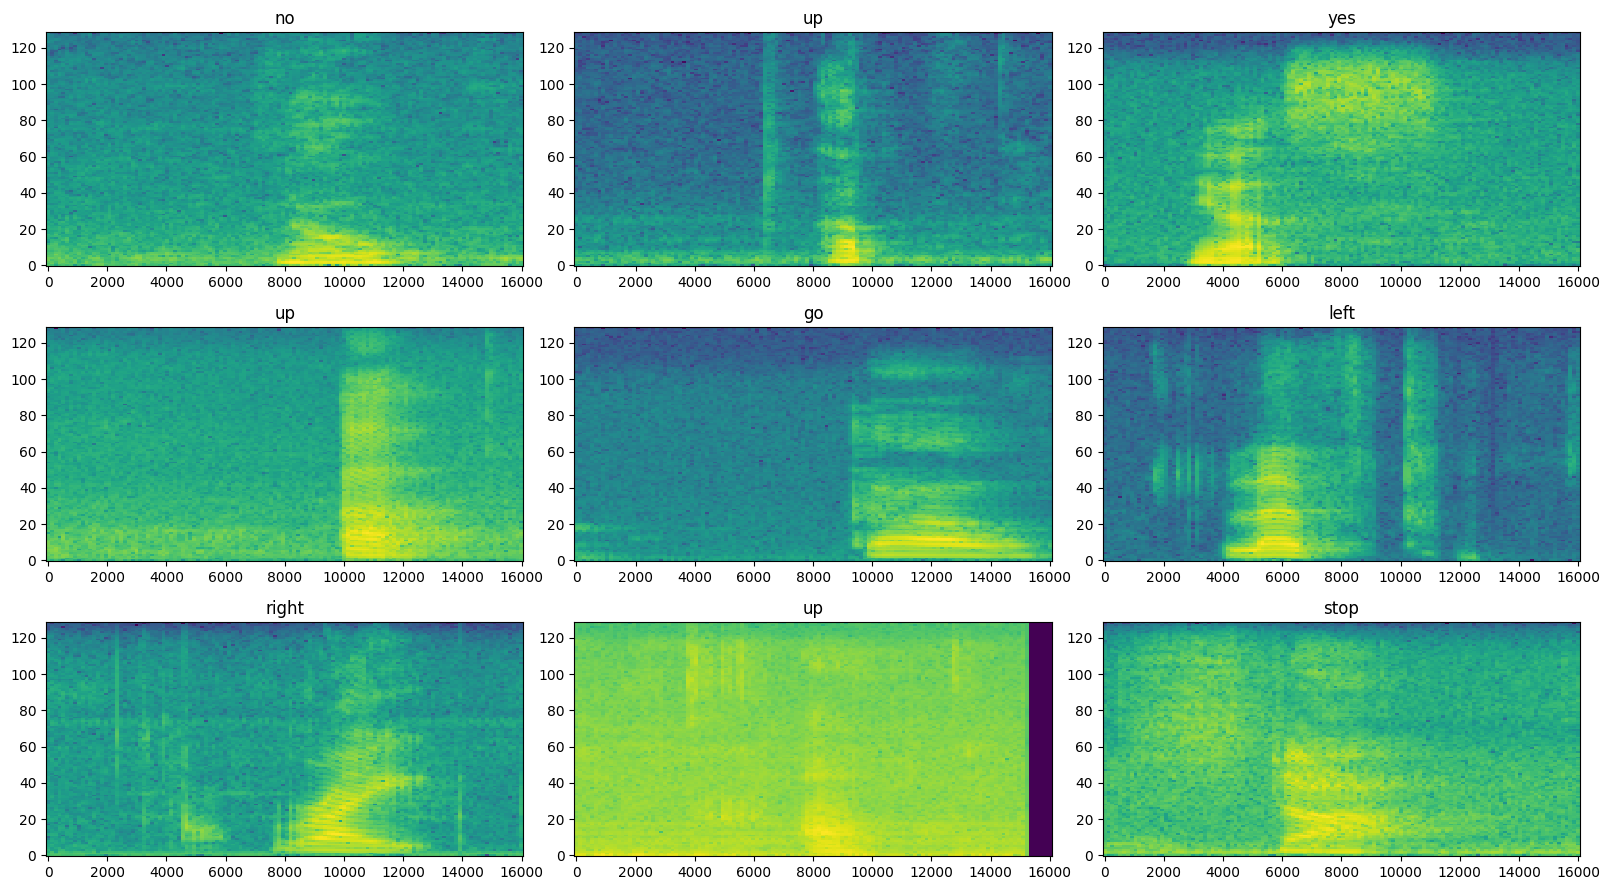

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])
plt.tight_layout()
plt.show()

# Build and train the model

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 43s 393ms/step - loss: 1.7266 - accuracy: 0.3908 - val_loss: 1.2939 - val_accuracy: 0.6224
Epoch 2/10
100/100 [==============================] - 40s 404ms/step - loss: 1.1535 - accuracy: 0.6039 - val_loss: 0.8852 - val_accuracy: 0.7331
Epoch 3/10
100/100 [==============================] - 39s 391ms/step - loss: 0.8637 - accuracy: 0.6958 - val_loss: 0.7302 - val_accuracy: 0.7878
Epoch 4/10
100/100 [==============================] - 36s 364ms/step - loss: 0.7170 - accuracy: 0.7502 - val_loss: 0.6577 - val_accuracy: 0.8086
Epoch 5/10
100/100 [==============================] - 31s 313ms/step - loss: 0.6111 - accuracy: 0.7848 - val_loss: 0.6123 - val_accuracy: 0.8255
Epoch 6/10
100/100 [==============================] - 29s 288ms/step - loss: 0.5436 - accuracy: 0.8130 - val_loss: 0.5567 - val_accuracy: 0.8281
Epoch 7/10
100/100 [==============================] - 29s 290ms/step - loss: 0.4888 - accuracy: 0.8216 - val_loss: 0.5200 - val_ac

Text(0, 0.5, 'Accuracy [%]')

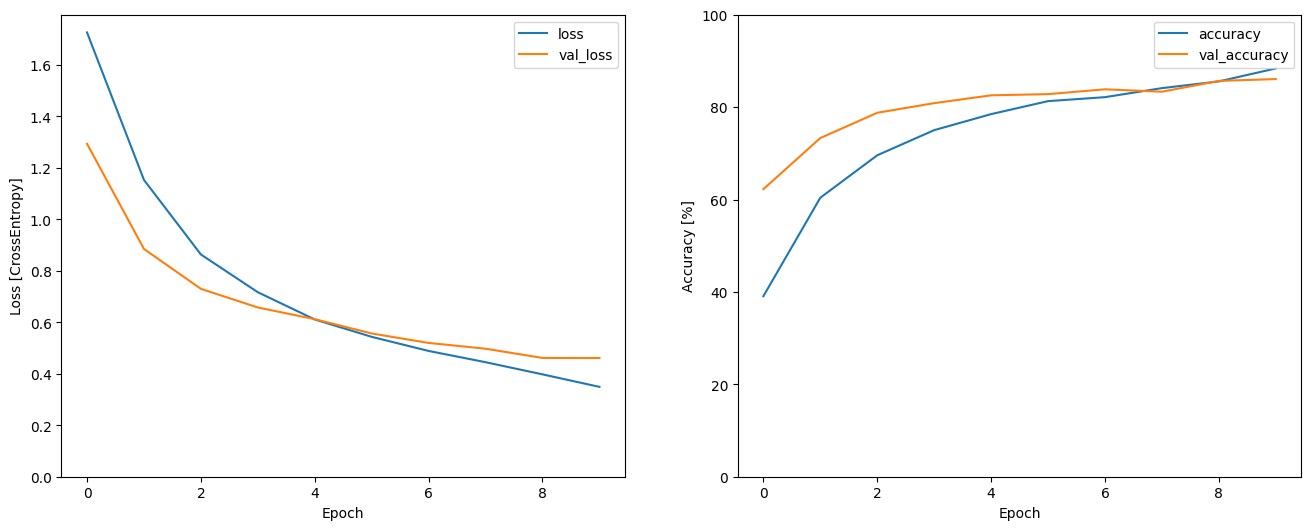

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 2s 163ms/step - loss: 0.5173 - accuracy: 0.8341


{'loss': 0.5173158049583435, 'accuracy': 0.8341346383094788}

## Display a confusion matrix

In [ ]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 1s 53ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

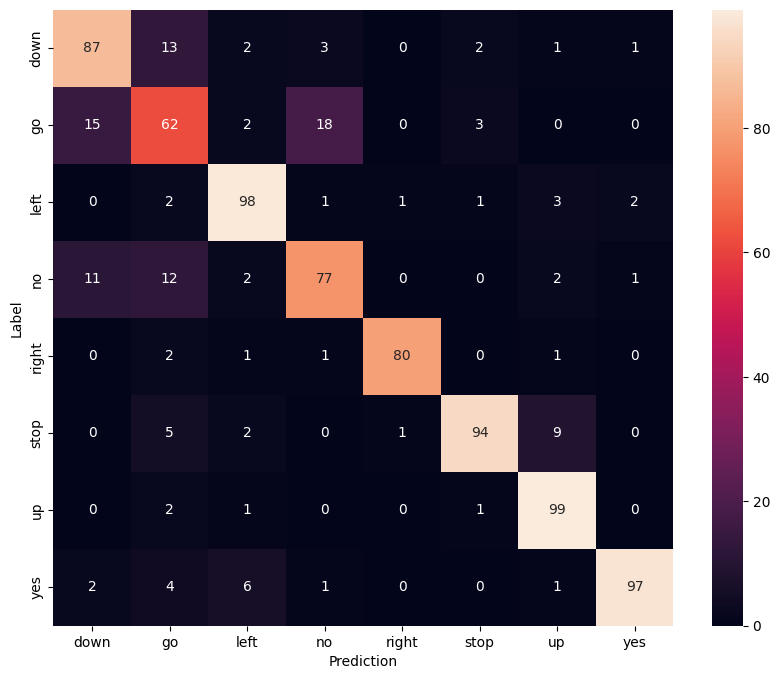

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

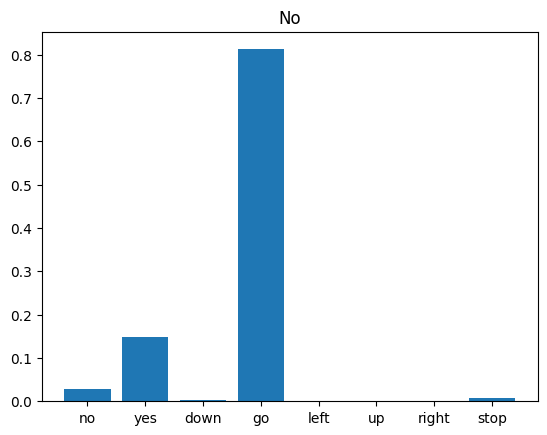

In [ ]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

# Export the model with preprocessing

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.6647731,  2.3551004, -1.5815372,  4.0603275, -3.4281795,
         -2.5847144, -2.7507148, -0.5820455]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.6647731,  2.3551004, -1.5815372,  4.0603275, -3.4281795,
         -2.5847144, -2.7507148, -0.5820455]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>}